In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import math
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import seaborn as sn
import matplotlib.pyplot as plt

## Modelo Lineal

In [2]:
#introducimos la base de datos
data = pd.read_csv('train.csv', index_col="Id")
#observamos la base de datos
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Para poder limpiar la base de datos categoricos,
#obsrvamos la info de la base
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [4]:
#Quitamos los datos que son 'object'
data_clean = data.select_dtypes(exclude=['object']).copy()
data_clean.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


In [5]:
#Quitamos los datos tipo NaN
data_clean.fillna(0,inplace = True)
#data_clean.to_csv('dataclean.csv',index = False)

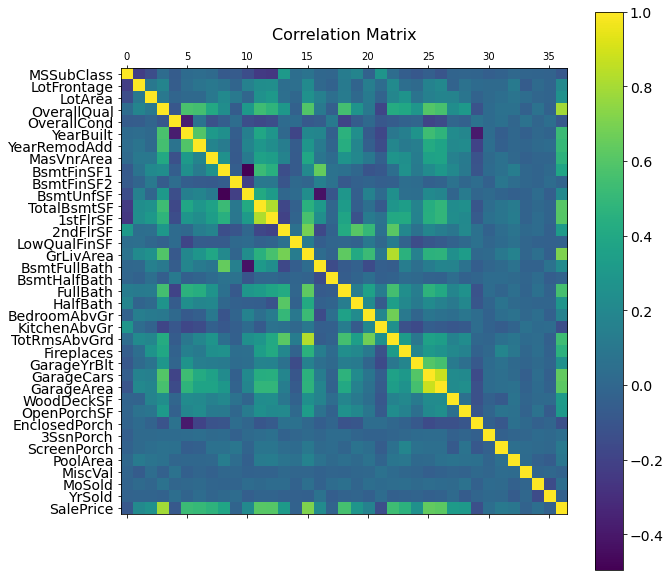

In [6]:
#Graficamos la matriz de correlaciones
f = plt.figure(figsize=(10,10))
plt.matshow(data_clean.corr(), fignum=f.number)
#plt.xticks(range(data_clean.shape[1]), data_clean.columns, fontsize=14, rotation=45)
plt.yticks(range(data_clean.shape[1]), data_clean.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [7]:
#Quitamos de la base las variables que no tienen tanta correlacion con la variable respuesta
corMatrix = data_clean.corr()
corMatrix['SalePrice']
#type(MC)
Resp_Corr=abs(corMatrix.loc[:,"SalePrice"])
#type(SaleCorr)
Resp_Opt=Resp_Corr.sort_values(ascending=False)
Explic=Resp_Opt.index[Resp_Opt>0.6]
Explic

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF'],
      dtype='object')

In [8]:
# Con base en la correlación, vamos a seleccionar las que tengan
# una > 0.6 con la variable respuesta.
train_selec = data_clean[Explic]

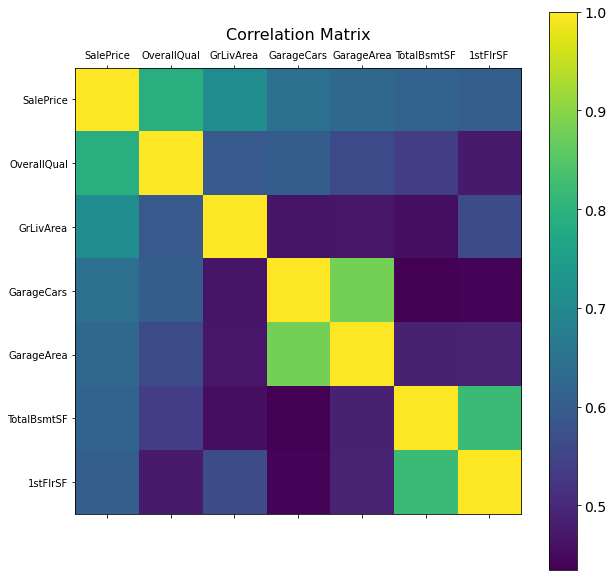

In [9]:
#Volvemos a graficar
f = plt.figure(figsize=(10, 10))
plt.matshow(train_selec.corr(), fignum=f.number)
plt.xticks(range(train_selec.shape[1]), train_selec.columns, fontsize=10)
plt.yticks(range(train_selec.shape[1]), train_selec.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [10]:
# Vemos que hay mucha multicolinealidad entre las parejas de variables
# "GarageCars"-"GarageArea" y "TotalBsmtSF"-"1stFlrSF". Entonces las
# vamos a quitar como sigue
train_selec=train_selec.drop(columns=['GarageCars', '1stFlrSF'])
train_selec

,SalePrice,OverallQual,GrLivArea,GarageArea,TotalBsmtSF
Id,,,,,
1,208500,7,1710,548,856
2,181500,6,1262,460,1262
3,223500,7,1786,608,920
4,140000,7,1717,642,756
5,250000,8,2198,836,1145
...,...,...,...,...,...
1456,175000,6,1647,460,953
1457,210000,6,2073,500,1542
1458,266500,7,2340,252,1152


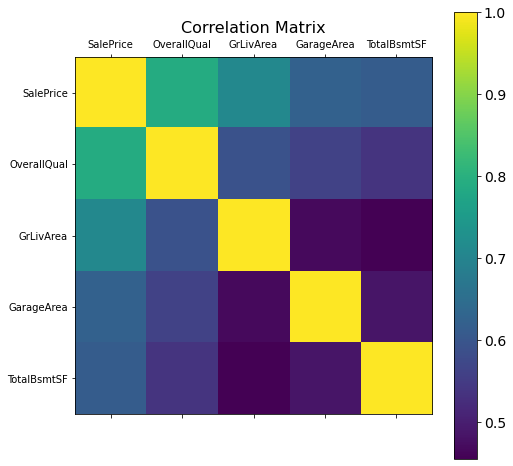

In [11]:
#Grafica
f = plt.figure(figsize=(8, 8))
plt.matshow(train_selec.corr(), fignum=f.number)
plt.xticks(range(train_selec.shape[1]), train_selec.columns, fontsize=10)
plt.yticks(range(train_selec.shape[1]), train_selec.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [14]:
#Obtenemos el modelo lineal
train_selec2 = train_selec.drop(columns=['SalePrice'])
linear_model = LinearRegression(normalize=False)
linear_model.fit(train_selec2,train_selec.SalePrice)
#imprimimos los coeficientes
linear_model.coef_

array([24954.7112341 ,    45.62768854,    58.24618968,    30.12648861])

## Modelo Lasso
Para el modelo Lasso tomamos todas las variables que no son categóricas.

In [15]:
data_clean2 = data_clean.drop(columns=['SalePrice'])
lasso_model = Lasso(alpha=0.5,normalize=True, max_iter=1e6)
lasso_model.fit(data_clean2,data_clean.SalePrice)
#imprimimos los coef
lasso_model.coef_

array([-1.66966189e+02,  8.83525402e+00,  3.92760746e-01,  1.73530318e+04,
        5.05987972e+03,  3.35301724e+02,  1.24045607e+02,  2.82298290e+01,
        1.01009616e+01,  5.41861121e-01, -0.00000000e+00,  8.49360732e+00,
        0.00000000e+00,  1.07909551e+00, -2.80641536e+01,  4.68706489e+01,
        8.51145287e+03,  1.65728384e+03,  3.22715897e+03, -1.78977948e+03,
       -1.01875182e+04, -1.55757586e+04,  4.93886212e+03,  4.08478519e+03,
       -1.44080007e+01,  1.56196461e+04,  4.89232465e+00,  2.58495798e+01,
       -5.72993864e+00,  1.10956315e+01,  2.02572548e+01,  5.72006429e+01,
       -3.21780638e+01, -4.28255779e-01, -3.80677391e+01, -6.96606170e+02])

## Predicciones
Aqui cargamos la base de datos test, para hacer predicciones con sus variables expliativas

In [17]:
test = pd.read_csv('test.csv', index_col="Id")
test_clean = test.select_dtypes(exclude=['object']).copy()
test_clean.fillna(0,inplace = True)
test_selec = test_clean[['OverallQual', 'GrLivArea','GarageArea','TotalBsmtSF']]
test_selec.head()

,OverallQual,GrLivArea,GarageArea,TotalBsmtSF
Id,,,,
1461,5,896,730.0,882.0
1462,6,1329,312.0,1329.0
1463,5,1629,482.0,928.0
1464,6,1604,470.0,926.0
1465,8,1280,506.0,1280.0


Creamos las variables para poder gráficarlas

In [18]:
Y = pd.read_csv('sample_submission.csv', index_col="Id")
y_test=linear_model.predict(test_selec)
y_testlasso = lasso_model.predict(test_clean)

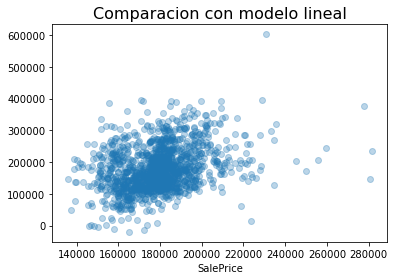

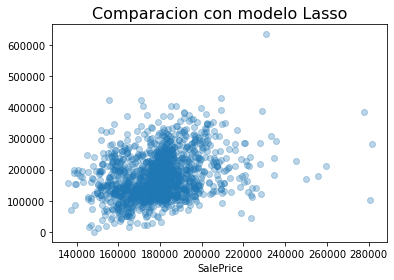

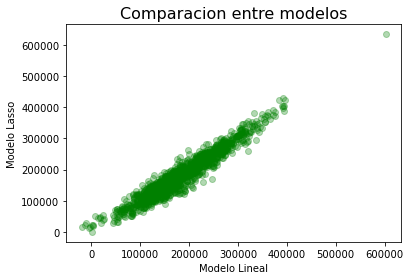

In [22]:
plt.scatter(Y.SalePrice,y_test, alpha = 0.3)
#plt.plot(test.x1, f(test),'r--', label='Data')
#plt.legend(loc='best', frameon=False)
plt.xlabel('SalePrice')
plt.title('Comparacion con modelo lineal', fontsize=16)
#plt.savefig('fdx.pdf', format='pdf', dpi=1200, bbox_inches="tight")
plt.show()

plt.scatter(Y.SalePrice,y_testlasso, alpha = 0.3)
plt.xlabel('SalePrice')
plt.title('Comparacion con modelo Lasso', fontsize=16)
plt.show()

plt.scatter(y_test,y_testlasso, color ='g', alpha = 0.3,)
plt.xlabel('Modelo Lineal')
plt.ylabel('Modelo Lasso')
plt.title('Comparacion entre modelos', fontsize=16)
plt.show()

## Conclusion
Los modelos en la gráfica parecen ser cercanos, a pesar de el Lasso ser más robusto. Así podemos tomar como modelo al lineal que toma menos variables pero toma las de más relación con la variable respuesta.